# <a id='toc1_'></a>[Large Sublimation Event Profiles](#toc0_)
Created October 1, 2024

Author: Daniel Hogan

This notebook will make plots for the different large sublimation events using the SOS dataset. The second portion will use the SAIL TROPOE dataset to make similar plots over a greater vertical distance.

**Table of contents**<a id='toc0_'></a>    
- [Large Sublimation Event Profiles](#toc1_)    
- [Imports and Data](#toc2_)    
    - [Open our SOS data](#toc2_1_1_)    
- [Data Preparation](#toc3_)    
    - [Convert Apogee temperatures](#toc3_1_1_)    
    - [Saturation with respect to ice](#toc3_1_2_)    
    - [Create variables for each desired data product](#toc3_1_3_)    
    - [Mask non-freezing RH wrt ice measurements](#toc3_1_4_)    
- [Plotting](#toc4_)    
    - [Select event](#toc4_1_1_)    
    - [Plotting functions](#toc4_1_2_)    
  - [Vertical Profiles - Relative Humidity wrt Ice + Temperature](#toc4_2_)    
  - [Vertical Profiles - Vapor Pressure Deficit + Potential Temperature](#toc4_3_)    
  - [Time Series - Energy Balance and Turublent Flux Comparisons](#toc4_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports and Data](#toc0_)

In [1]:
# general
import datetime as dt
# data 
import xarray as xr 
import numpy as np
import pandas as pd
from scipy import stats as stats 
import statsmodels.api as sm

# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.4.4


### <a id='toc2_1_1_'></a>[Open our SOS data](#toc0_)

In [2]:
sos_30min = xr.open_dataset('../../01_data/processed_data/sos/sos_ds_30M_storage.nc')
# calculate longwave radiation for SOS data
SIGMA = 5.67e-8
sos_30min = sos_30min.assign(R_lw_up = ((sos_30min.Rpile_out_9m_d + (sos_30min.Tcase_out_9m_d+273.15)**4*SIGMA)))
sos_30min = sos_30min.assign(R_lw_down = ((sos_30min.Rpile_in_9m_d + (sos_30min.Tcase_in_9m_d+273.15)**4*SIGMA)))

In [250]:
# exploring the quality of extreme values
data = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__10m' in var]].to_pandas()
quantile = data.quantile([0.99])
data = data[data > quantile.iloc[0]].dropna(how='all')


,w_h2o__10m_uw,w_h2o__10m_ue,w_h2o__10m_d,w_h2o__10m_c
time,,,,
2022-12-21 06:00:00,NaN,NaN,NaN,0.083682
2022-12-31 07:30:00,NaN,NaN,NaN,0.101774
2023-02-15 03:00:00,NaN,NaN,NaN,0.083756
2023-03-02 17:00:00,NaN,NaN,0.074187,NaN
2023-03-04 06:00:00,0.103730,NaN,NaN,NaN
...,...,...,...,...
2023-06-18 22:00:00,NaN,0.074657,0.093855,NaN
2023-06-19 14:30:00,0.082444,0.078546,NaN,NaN
2023-06-19 15:00:00,NaN,0.076427,NaN,0.080720


### Open SAIL TROPOE Data

In [219]:
variables = ['temperature', 'waterVapor', 'lwp','theta','thetae','rh', 'pblh', 'pblh', 'sbih', 'obs_flag']
w23_sail_tropoe = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/tropoe_20221201_20230401.nc')[variables]

### Open Large Sublimation Events

In [220]:
# load in the big events from winter 2023
w23_long_events = pd.read_csv('../../01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')
w23_spiky_events =pd.read_csv('../../01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')

# get the start and end datetimes of the events
long_events_start = w23_long_events.reset_index().groupby('event').first()['time']
long_events_end = w23_long_events.reset_index().groupby('event').last()['time']
spiky_events_start = w23_spiky_events.reset_index().groupby('event').first()['time']
spiky_events_end = w23_spiky_events.reset_index().groupby('event').last()['time']

# <a id='toc3_'></a>[Data Preparation](#toc0_)

### <a id='toc3_1_1_'></a>[Convert Apogee temperatures](#toc0_)

In [221]:
# functions I will need 
def apogee2temp(dat,tower):
# hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = dat[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
# unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861,58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285,287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932,2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453,-214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657,-0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234,0.10936][im]* 1e5
# read data
    Vtherm = dat[f"Vtherm_{tower}"]
    Vpile = dat[f"Vpile_{tower}"]*1000
# calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
# finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    TTc = TTc
    return TTc

### <a id='toc3_1_2_'></a>[Saturation with respect to ice](#toc0_)

In [222]:
# correct the RH values to make them with respect to ice
def saturation_vapor_pressure_wrt_ice(T, method='Huang'):
    # from Huang et al. 2018
    if method == 'Huang':
        Ps = np.exp(43.494 - (6545.8 / (T + 278.0)))/((T + 868)**2)
    elif method == 'Magnus':
        # From (Alduchov and Eskridge 1996).
        Ps = 611.21 * np.exp((22.587*T)/(T + 273.86))
    return Ps
def saturation_vapor_pressure_wrt_water(T, method='Huang'):
    if method == 'Huang':
        # from Huang et al. 2018
        Ps = np.exp(34.494 - (4924.99 / (T + 237.1)))/((T+105)**1.57)
    if method == 'Magnus':
    # From (Alduchov and Eskridge 1996).
        Ps = 610.94 * np.exp((17.625*T)/(T + 243.04))
    return Ps

cold_temp_array = np.arange(-20, 0, 1)
warm_temp_array = np.arange(-20, 0, 1)
sat_vap_pres_ice_huang = saturation_vapor_pressure_wrt_ice(cold_temp_array)
sat_vap_pres_ice_magnus= saturation_vapor_pressure_wrt_ice(cold_temp_array, method='Magnus')
sat_vap_pres_water_huang = saturation_vapor_pressure_wrt_water(warm_temp_array)
sat_vap_pres_water_magnus = saturation_vapor_pressure_wrt_water(warm_temp_array, method='Magnus')

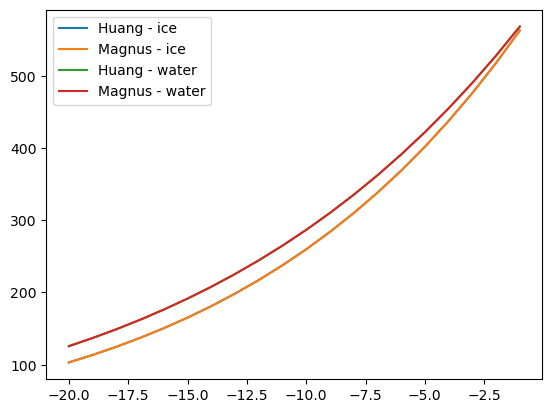

In [223]:
# Testing to compare
plt.plot(cold_temp_array, sat_vap_pres_ice_huang, label='Huang - ice')
plt.plot(cold_temp_array, sat_vap_pres_ice_magnus, label='Magnus - ice')
plt.plot(warm_temp_array, sat_vap_pres_water_huang, label='Huang - water')
plt.plot(warm_temp_array, sat_vap_pres_water_magnus, label='Magnus - water')
plt.legend()

In [224]:
# surface temperature
sos_30min = sos_30min.assign(Tsurfapogee_d=apogee2temp(sos_30min,'d'))
sos_30min = sos_30min.assign(Tsurfapogee_c=apogee2temp(sos_30min,'c'))
sos_30min = sos_30min.assign(Tsurfapogee_uw=apogee2temp(sos_30min,'uw'))
sos_30min = sos_30min.assign(Tsurfapogee_ue=apogee2temp(sos_30min,'ue'))

### <a id='toc3_1_3_'></a>[Create variables for each desired data product](#toc0_)

In [225]:
sos_30min_RH = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'RH' in var]] 
sos_30min_T = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'T' in var]] * units.units('degC')
sos_30min_winds = sos_30min[[var for var in hf.WIND_VARIABLES if 'spd' in var or 'dir' in var]] 
sos_30min_swe = sos_30min[['SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c']].to_array(dim='snow').mean('snow') # estimate of bulk density
sos_30min_snow_depth_est = (sos_30min_swe)/250 # convert from mm of depth to meters of snow by converting to meters and multiplying by 250 kg/m^3
# surface temperature
sos_30min_Tsurf_d = sos_30min['Tsurfapogee_d'] # can also take spatial mean if I want
# sublimation rate
sos_30min_ec_h2o = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__3m' in var]].to_array(dim='3m').mean('3m')
sos_30min_ec_temp = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_tc__3m' in var]].to_array(dim='3m').mean('3m')
# blowing snow flux
sos_30min_bsf = sos_30min[[var for var in hf.SNOW_FLUX]].to_array(dim='total').sum('total')
# radiation
sos_30min_rad = sos_30min[[var for var in hf.RADIAION_VARIABLES if 'R' in var]+['R_lw_up', 'R_lw_down']].dropna(dim='time')
# remove any times when Rsw_in_9m_d is less than Rsw_out_9m_d
sos_30min_rad = sos_30min_rad.where((sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d'])>-10,)
# calculate net radiation
sos_30min_rad['rnet'] = (sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d']) + (sos_30min_rad['R_lw_down'] - sos_30min_rad['R_lw_up'])

# calculate pressure, mixing ratio and air density
heights = np.arange(2,21,1)
pressureprofiles = []
mixingratios = []
airdensities = []
vaporpressures = []
satvaporpressures = []
vpds = []
thetas = []
for h in heights:
    # calculate pressure
    pressure = calc.height_to_pressure_std(
                                calc.pressure_to_height_std(sos_30min['P_10m_c']*units.units('hPa')) - ((10 - h)/1000)*units.units('km'))
    pressure.name = f'P_{h}m_c'
    # calculate mixing ratio
    mixingratio = calc.mixing_ratio_from_relative_humidity(pressure, sos_30min_T[f'T_{h}m_c'], sos_30min_RH[f'RH_{h}m_c'])
    mixingratio.name=f'w_{h}m_c'
    # calculate air density
    airdensity = calc.density(pressure, sos_30min_T[f'T_{h}m_c'], mixingratio)
    airdensity.name = f'rho_{h}m_c'
    # calculate vapor pressure
    vaporpressure = calc.vapor_pressure(pressure, mixingratio)
    vaporpressure.name = f'e_{h}m_c'
    # calculate saturation vapor pressure
    satvaporpressure = saturation_vapor_pressure_wrt_ice(sos_30min_T['T_10m_c'].metpy.dequantify()) * units.units('Pa')
    satvaporpressure.name = f'es_{h}m_c'
    # calculate vapor pressure deficit
    vaporpressuredeficit = satvaporpressure - vaporpressure
    vaporpressuredeficit.name = f'vpd_{h}m_c'
    # calculate potential temperature
    sos_30min_theta = calc.potential_temperature(pressure, sos_30min_T[f'T_{h}m_c'])
    sos_30min_theta.name = f'Theta_{h}m_c'

    # append to lists
    pressureprofiles.append(pressure)
    mixingratios.append(mixingratio)
    airdensities.append(airdensity)
    vaporpressures.append(vaporpressure)
    satvaporpressures.append(satvaporpressure)
    vpds.append(vaporpressuredeficit)
    thetas.append(sos_30min_theta)


# Create xarray datasets
sos_30min_pressure_profiles = xr.merge(pressureprofiles)
sos_30min_mixing_ratio = xr.merge(mixingratios)
sos_30min_airdensity = xr.merge(airdensities) 
sos_30min_vaporpressure = xr.merge(vaporpressures) 
sos_30min_satvaporpressure = xr.merge(satvaporpressures) 
sos_30min_vpd = xr.merge(vpds)
sos_30min_theta = xr.merge(thetas) 

# daytime is anytime when difference between Rsw_in_9m_d and Rsw_out_9m_d is greater than 10 W/m^2
sos_30min_rad['daytime'] = sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d'] > 10
sos_30min_rad['nighttime'] = sos_30min_rad['daytime'] == False

### <a id='toc3_1_4_'></a>[Mask non-freezing RH wrt ice measurements](#toc0_)

In [226]:
sos_30min_RH_ice = sos_30min_RH.copy()
# covert to RH with respect to ice by multiplying with the ratio of the saturation vapor pressure of water and ice
for var in sos_30min_RH_ice:
    if 'RH' in var:
        T_var = var.replace('RH', 'T')
        # create a mask where T is below 0
        mask = sos_30min_T[T_var] > 0
        # use the mask to calculate RH with respect to ice
        sos_30min_RH_ice[var] = sos_30min_RH_ice[var].where(mask, sos_30min_RH_ice[var] * saturation_vapor_pressure_wrt_water(sos_30min_T[T_var].values)/saturation_vapor_pressure_wrt_ice(sos_30min_T[T_var].values))

# Select Event

In [227]:
# now lets select a large sublimation event to visualize
start, end = long_events_start.iloc[0], long_events_end.iloc[0]
# get data for plots
sos_30min_RH_ice_sel = sos_30min_RH_ice.sel(time=slice(start, end))
sos_30min_T_sel = sos_30min_T.sel(time=slice(start, end))
sos_30min_winds_sel = sos_30min_winds.sel(time=slice(start, end))
sos_30min_snow_depth_sel = sos_30min_snow_depth_est.sel(time=slice(start, end))
sos_30min_bsf_sel = sos_30min_bsf.sel(time=slice(start, end))
sos_30min_Tsurf_d_sel = sos_30min_Tsurf_d.sel(time=slice(start, end))
sos_30min_mixing_ratio_sel = sos_30min_mixing_ratio.sel(time=slice(start, end)) * 1000*units.units('g/kg')
sos_30min_vaporpressure_sel = sos_30min_vaporpressure.sel(time=slice(start, end))
sos_30min_satvaporpressure_sel = sos_30min_satvaporpressure.sel(time=slice(start, end))
sos_30min_vpd_sel = sos_30min_vpd.sel(time=slice(start, end))
sos_30min_theta_sel = sos_30min_theta.sel(time=slice(start, end))

# daytime and nighttime
sos_30min_daynight_sel = sos_30min_rad.sel(time=slice(start, end))[['daytime', 'nighttime']]
# net radiation
sos_30min_rnet_sel = sos_30min_rad.sel(time=slice(start, end))['rnet']

# TROPOE data
w23_sail_tropoe_sel = w23_sail_tropoe.sel(time=slice(start, end), height=slice(0,3)).resample(time='30min').mean()

### Calculate turbulent heat fluxes for sublimation!!!!
# Constant values
rho_w = 1000 * units.units('kg/m^3') # density of water kg/m^3
g2kg = (1/1000 * units.units('kg/g')) # convert from g to kg
mm_per_meter = 1000 * units.units('mm/m') # convert from m to mm
s_in_hour = 3600 * units.units('seconds/hour') # seconds in an hour
latent_heat_sublimation = 2.835e6 * units.units('J/kg') # latent heat of sublimation J/kg
# heat_capacity_air units J/kg/C
heat_capacity_air = (1005)*units.units('J/kg/C') # J/kg/C

sos_30min_sublimation_sel = (sos_30min_ec_h2o.sel(time=slice(start, end))*units.units('g/m^3 * m/s')) * 1/rho_w * g2kg * mm_per_meter * s_in_hour # convert from g/m^2/s to mm/hr
sos_30min_latent_heat_sel = sos_30min_sublimation_sel * latent_heat_sublimation / mm_per_meter * rho_w / s_in_hour # convert to W/m^2
# using the 3 meter data
sos_30min_sensible_heat_sel = heat_capacity_air*(sos_30min_ec_temp*units.units('deg * m/s')*sos_30min_airdensity['rho_3m_c']).sel(time=slice(start, end)) # convert to W/m^2 from degC * m/s

In [228]:
# name all the variables
sos_30min_bsf_sel.name = 'bsf'
sos_30min_rnet_sel.name = 'rnet'
sos_30min_sublimation_sel.name = 'sublimation'
sos_30min_latent_heat_sel.name = 'latent_heat'
sos_30min_sensible_heat_sel.name = 'sensible_heat'

# <a id='toc4_'></a>[ SOS Data Plotting](#toc0_)

### <a id='toc4_1_2_'></a>[Plotting functions](#toc0_)

In [229]:
# prepare data for wind barbs
def create_wind_barbs(wind_data, level):
    spd = wind_data[[var for var in hf.WIND_VARIABLES if f'spd_{level}m' in var]].to_pandas()
    dir = wind_data[[var for var in hf.WIND_VARIABLES if f'dir_{level}m' in var]].to_pandas()
    md = 270 - dir.values
    md[md < 0] += 360
    u = (spd * np.cos(np.deg2rad(md))).mean(axis=1).values
    v = (spd * np.sin(np.deg2rad(md))).mean(axis=1).values
    time = wind_data.time.values
    level = np.ones_like(u) * level
    return u,v,time,level

In [230]:
def variable_linear_regression(ds1, ds2, daynight=None):
    ds = xr.merge([ds1, ds2])
    if daynight:
        if len(daynight['daytime'].time) < len(ds.time):
            # daytime are hours between 14 and 00
            day_hours = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]
            ds_day = ds.where(ds.time.dt.hour.isin(day_hours), drop=True).dropna(dim='time')
            # nighttime are hours between 1 and 13
            night_hours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
            ds_night = ds.where(ds.time.dt.hour.isin(night_hours), drop=True).dropna(dim='time')
        else:
            # get values during daytime
            ds_day = ds.where(ds.sel(time=daynight['daytime']), drop=True).dropna(dim='time')
            # get values during nighttime
            ds_night = ds.where(ds.sel(time=daynight['nighttime']), drop=True).dropna(dim='time')
        # calculate linear regression for daytime
        slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(ds_day[ds1.name].values, ds_day[ds2.name].values)
        X_day = ds_day[ds1.name].values
        Y_day = slope_day * X_day + intercept_day
        # calculate linear regression for nighttime
        slope_night, intercept_night, r_value_night, p_value_night, std_err_night = stats.linregress(ds_night[ds1.name].values, ds_night[ds2.name].values)
        X_night = ds_night[ds1.name].values
        Y_night = slope_night * X_night + intercept_night
        results_dict = dict(
            X_day=X_day,
            Y_day=Y_day,
            r_value_day=r_value_day,
            X_night=X_night,
            Y_night=Y_night,
            r_value_night=r_value_night,
            combined_ds=ds
        )
        return results_dict
        
    else:
        ds = ds.dropna(dim='time')
        slope, intercept, r_value, p_value, std_err = stats.linregress(ds[ds1.name].values, ds[ds2.name].values)
        X = ds[ds1.name].values
        Y = slope * X + intercept
    return dict(X=X, Y=Y, slope=slope, r_value=r_value, combined_ds=ds)

In [231]:
# Define the colors: brown, white, and pink
colors = ['goldenrod', 'white', 'magenta']

# Create the colormap
cmap = LinearSegmentedColormap.from_list('brown_white_pink', colors)
cmap_r = LinearSegmentedColormap.from_list('brown_white_pink_r', colors[::-1])

## <a id='toc4_2_'></a>[Vertical Profiles - Relative Humidity wrt Ice + Temperature](#toc0_)

(0.0, 11.0)

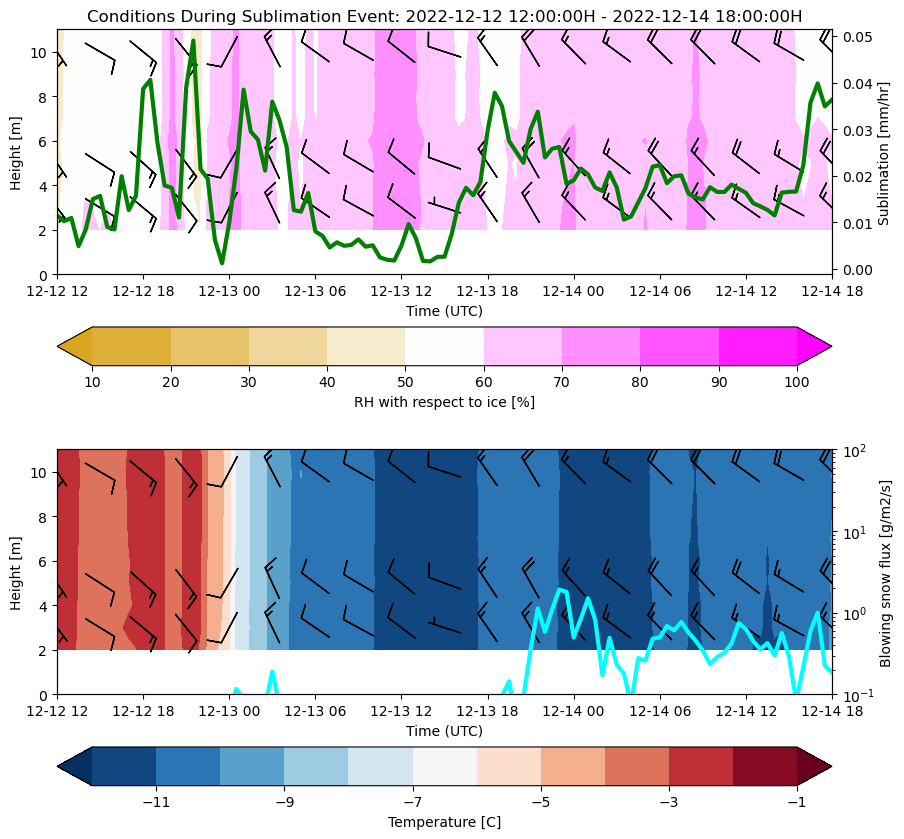

In [232]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,10))
x = sos_30min_RH_ice_sel.time.values
y = np.arange(2,12,1)
z_rh = sos_30min_RH_ice_sel.to_pandas().T.iloc[0:10]
z_t = sos_30min_T_sel.to_pandas().T.iloc[0:10]
# linear interpolate missing values
z_rh = z_rh.interpolate(method='linear', limit=2)
# z_t = z_t.interpolate(method='linear')

# Plot the contours of RH
ax = axs[0]
# ax.contour(x, y, z_rh, colors='k', levels=np.arange(40,101,10))
c_rh = ax.contourf(x, y, z_rh, cmap=cmap, levels=np.arange(10,101,10), extend='both')
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='green', linestyle='-', lw=3, label='Sublimation @ 3m [mm/hr]')
ax2.set_ylabel('Sublimation [mm/hr]')
# add wind barbs at 10m every 9 measurements
barb_increments = dict(half=2.5, full=5, flag=26)
if len(sos_30min_winds_sel.time) > 36:
    interval = 6
else:
    interval = 3
barb_data = [[create_wind_barbs(sos_30min_winds_sel, 3)],
             [create_wind_barbs(sos_30min_winds_sel, 5)],
             [create_wind_barbs(sos_30min_winds_sel, 10)]]
            #  [create_wind_barbs(sos_30min_winds_sel, 15)],
            #  [create_wind_barbs(sos_30min_winds_sel, 20)]]
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')

fig.colorbar(c_rh, ax=ax, label='RH with respect to ice [%]', orientation='horizontal')
ax.set_title(f'Conditions During Sublimation Event: {start}H - {end}H')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(0,11)


# Second plot contours of temperature
ax= axs[1]

c_t = ax.contourf(x, y, z_t, cmap='RdBu_r', levels=np.arange(-12,0,1), extend='both')
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')
ax2 = ax.twinx()
# also think of adding the sublimation rate
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='cyan', linestyle='-', lw=3, label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux [g/m2/s]')
ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)
# create third y-axis for blowing snow flux
fig.colorbar(c_t, ax=ax, label='Temperature [C]', orientation='horizontal')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(0,11)


## <a id='toc4_3_'></a>[Vertical Profiles - Vapor Pressure Deficit + Potential Temperature](#toc0_)

(0.0, 11.0)

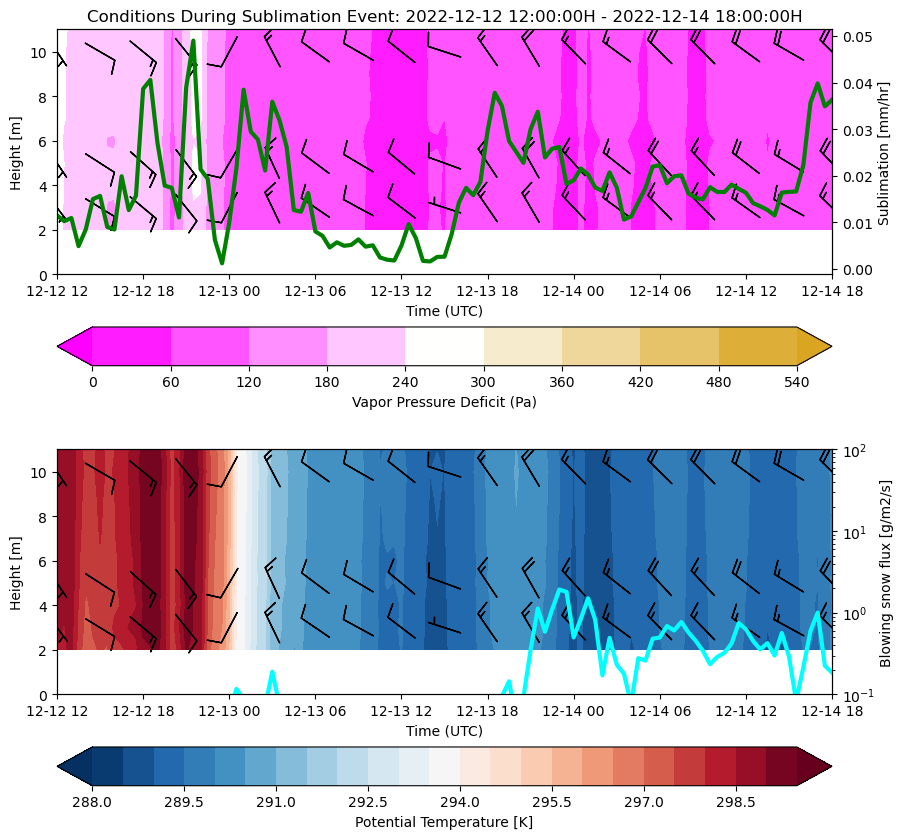

In [233]:
# now try this with matplotlib
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,10))
x = sos_30min_vpd_sel.time.values
y = np.arange(2,12,1)
z_vpd = sos_30min_vpd_sel.to_pandas().T.iloc[0:10]
z_t = sos_30min_theta_sel.to_pandas().T.iloc[0:10]
# linear interpolate missing values
z_vpd = z_vpd.interpolate(method='linear', limit=2)
# z_t = z_t.interpolate(method='linear')

# Plot the contours of RH
ax = axs[0]
# ax.contour(x, y, z_vpd, colors='k', levels=np.arange(40,101,10))
c_w = ax.contourf(x, y, z_vpd, cmap=cmap_r, levels=np.arange(0,600,60), extend='both')
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='green', linestyle='-', lw=3, label='Sublimation @ 3m [mm/hr]')
ax2.set_ylabel('Sublimation [mm/hr]')
# add wind barbs at 10m every 9 measurements
barb_increments = dict(half=2.5, full=5, flag=26)
if len(sos_30min_winds_sel.time) > 36:
    interval = 6
else:
    interval = 3
barb_data = [[create_wind_barbs(sos_30min_winds_sel, 3)],
             [create_wind_barbs(sos_30min_winds_sel, 5)],
             [create_wind_barbs(sos_30min_winds_sel, 10)]]
            #  [create_wind_barbs(sos_30min_winds_sel, 15)],
            #  [create_wind_barbs(sos_30min_winds_sel, 20)]]
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')

fig.colorbar(c_w, ax=ax, label='Vapor Pressure Deficit (Pa)', orientation='horizontal')
ax.set_title(f'Conditions During Sublimation Event: {start}H - {end}H')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(0,11)


# Second plot contours of temperature
ax= axs[1]

c_t = ax.contourf(x, y, z_t, cmap='RdBu_r', levels=np.arange(288,300,0.5), extend='both')
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')
ax2 = ax.twinx()
# also think of adding the sublimation rate
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='cyan', linestyle='-', lw=3, label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux [g/m2/s]')
ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)
# create third y-axis for blowing snow flux
fig.colorbar(c_t, ax=ax, label='Potential Temperature [K]', orientation='horizontal')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(0,11)


## <a id='toc4_4_'></a>[Time Series - Energy Balance and Turublent Flux Comparisons](#toc0_)

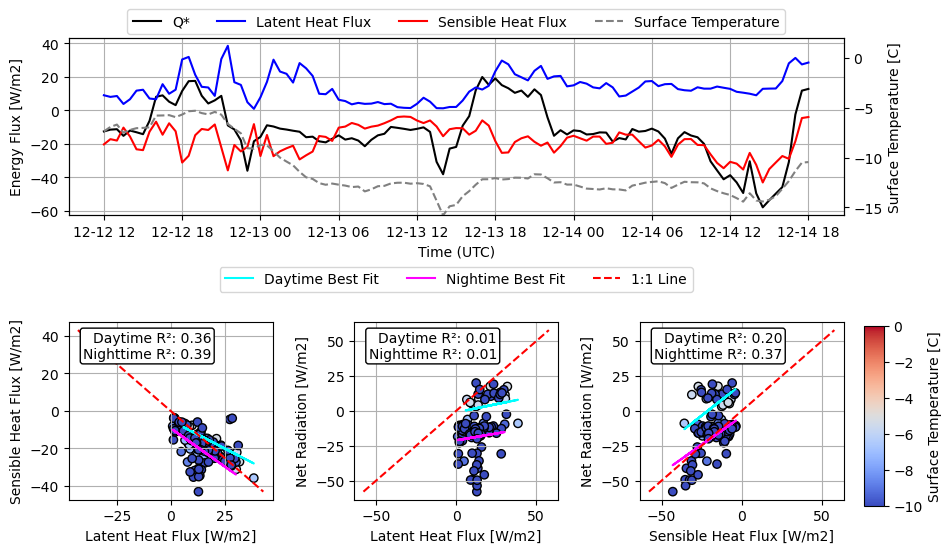

In [234]:
# Create a figure with gridspec layout
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, height_ratios=[0.5, 0.5], width_ratios=[0.3, 0.3, 0.3], hspace=0.6, wspace=0.4)

# Top plot: Net Radiation over time
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(sos_30min_rnet_sel.time.values, sos_30min_rnet_sel.values, label='Q*', color='black')
ax1.plot(sos_30min_latent_heat_sel.time.values, sos_30min_latent_heat_sel.values, label='Latent Heat Flux', color='blue')
ax1.plot(sos_30min_sensible_heat_sel.time.values, sos_30min_sensible_heat_sel.values, label='Sensible Heat Flux', color='red')
ax1.plot([],[], label='Surface Temperature', color='grey', linestyle='--')
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Energy Flux [W/m2]')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)

ax1_twin = ax1.twinx()
ax1_twin.plot(sos_30min_Tsurf_d_sel.time.values, sos_30min_Tsurf_d_sel.values, color='grey', linestyle='--')
ax1_twin.set_ylabel('Surface Temperature [C]')
ax1_twin.set_ylim(sos_30min_Tsurf_d_sel.min(), 2)
ax1.grid(True)

# Filter times when surface temperature is near 0
sos_30min_Tsurf_d_sel_warm = sos_30min_Tsurf_d_sel.where((sos_30min_Tsurf_d_sel > -0.5), drop=True)
sos_30min_Tsurf_d_sel_cold = sos_30min_Tsurf_d_sel.where((sos_30min_Tsurf_d_sel < -0.5), drop=True)

# Lower left: Latent vs Sensible Heat Flux
ax2 = fig.add_subplot(gs[1, 0])
# calculate best fit line
best_fit_results = variable_linear_regression(sos_30min_latent_heat_sel, sos_30min_sensible_heat_sel, daynight=sos_30min_daynight_sel)
ax2.plot(best_fit_results['X_day'], best_fit_results['Y_day'], color='cyan')
ax2.plot(best_fit_results['X_night'], best_fit_results['Y_night'], color='magenta')
# annotate the R2 in upper right corner
ax2.text(0.7, 0.95, f"Daytime R²: {best_fit_results['r_value_day']**2:.2f}\nNighttime R²: {best_fit_results['r_value_night']**2:.2f}", ha='right', va='top', transform=ax2.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
ax2.scatter(sos_30min_latent_heat_sel.values, sos_30min_sensible_heat_sel.values, 
            c=sos_30min_Tsurf_d_sel.values, 
            cmap='coolwarm',
            vmin=-10, vmax=0, 
            ec='black')
# scale the 1:1 line with the same limits as the data
# find the absolute max of the data
max_val = max(abs(np.array([sos_30min_latent_heat_sel.max(), sos_30min_sensible_heat_sel.max(), sos_30min_latent_heat_sel.min(), sos_30min_sensible_heat_sel.min()])))
ax2.plot([-max_val, max_val], [max_val, -max_val], linestyle='--', color='red', label='1:1 Line')
ax2.set_xlabel('Latent Heat Flux [W/m2]')
ax2.set_ylabel('Sensible Heat Flux [W/m2]')
ax2.grid(True)

# Lower center: Latent Heat Flux vs Net Radiation
ax3 = fig.add_subplot(gs[1, 1])
# calculate best fit line
if len(sos_30min_rnet_sel.time) < len(sos_30min_latent_heat_sel.time)-5:
    print('Not enough data points for regression')
    # plot on figure this text
    ax3.text(0.5, 0.5, 'Not enough data points for regression', ha='center', va='center', transform=ax3.transAxes)
else:
    best_fit_results = variable_linear_regression(sos_30min_latent_heat_sel, sos_30min_rnet_sel, daynight=sos_30min_daynight_sel)
    ax3.plot(best_fit_results['X_day'], best_fit_results['Y_day'], color='cyan', label='Daytime Best Fit')
    ax3.plot(best_fit_results['X_night'], best_fit_results['Y_night'], color='magenta', label='Nightime Best Fit')
    # annotate the R2 in upper right corner
    ax3.text(0.7, 0.95, f"Daytime R²: {best_fit_results['r_value_day']**2:.2f}\nNighttime R²: {best_fit_results['r_value_night']**2:.2f}", ha='right', va='top', transform=ax3.transAxes,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

    max_val = max(abs(np.array([sos_30min_latent_heat_sel.max(), sos_30min_rnet_sel.max(), sos_30min_latent_heat_sel.min(), sos_30min_rnet_sel.min()])))
    ax3.plot([-max_val, max_val], [-max_val, max_val], linestyle='--', color='red', label='1:1 Line')
    ax3.scatter(best_fit_results['combined_ds']['latent_heat'].values, best_fit_results['combined_ds']['rnet'].values, 
            c=sos_30min_Tsurf_d_sel.values, 
            cmap='coolwarm',
            vmin=-10, vmax=0, 
            ec='black')
    ax3.set_xlabel('Latent Heat Flux [W/m2]')
    ax3.set_ylabel('Net Radiation [W/m2]')
    ax3.grid(True)
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35,), ncols=3)

# Lower right: Sensible Heat Flux vs Net Radiation
ax4 = fig.add_subplot(gs[1, 2])
if len(sos_30min_rnet_sel) < len(sos_30min_sensible_heat_sel.time)-5:
    print('Not enough data points for regression')
    # plot on figure this text
    ax4.text(0.5, 0.5, 'Not enough data points for regression', ha='center', va='center', transform=ax4.transAxes)
else:
    best_fit_results = variable_linear_regression(sos_30min_sensible_heat_sel, sos_30min_rnet_sel, daynight=sos_30min_daynight_sel)
    ax4.plot(best_fit_results['X_day'], best_fit_results['Y_day'], color='cyan')
    ax4.plot(best_fit_results['X_night'], best_fit_results['Y_night'], color='magenta')
    # annotate the R2 in upper right corner
    ax4.text(0.7, 0.95, f"Daytime R²: {best_fit_results['r_value_day']**2:.2f}\nNighttime R²: {best_fit_results['r_value_night']**2:.2f}", ha='right', va='top', transform=ax4.transAxes,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

    ax4.scatter(best_fit_results['combined_ds']['sensible_heat'].values, best_fit_results['combined_ds']['rnet'].values, 
                c=sos_30min_Tsurf_d_sel.values, 
                cmap='coolwarm',
                vmin=-10, vmax=0, 
                ec='black')
    max_val = max(abs(np.array([sos_30min_sensible_heat_sel.max(), sos_30min_rnet_sel.max(), sos_30min_sensible_heat_sel.min(), sos_30min_rnet_sel.min()])))
    ax4.plot([-max_val, max_val], [-max_val, max_val], linestyle='--', color='red', label='1:1 Line')
    ax4.set_xlabel('Sensible Heat Flux [W/m2]')
    ax4.set_ylabel('Net Radiation [W/m2]')
    ax4.grid(True)
# add colorbar to the right
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.3])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(-10, 0)), cax=cbar_ax, label='Surface Temperature [C]')

    


# Plotting with TROPOE

(0.0, 1.0)

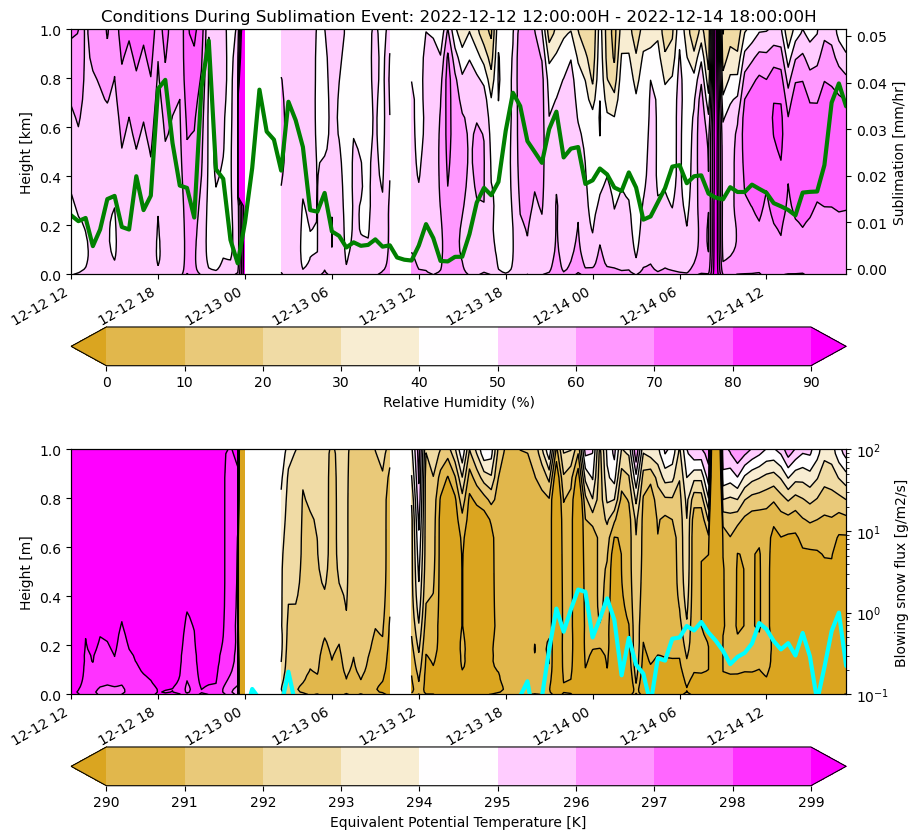

In [237]:
# now try this with matplotlib
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,10))

# Plot the contours of RH
ax = axs[0]
c_rh = w23_sail_tropoe_sel['rh'].plot.contourf(x='time',ax=ax, levels=np.arange(0,100,10), cmap=cmap, extend='both', add_colorbar=False)
w23_sail_tropoe_sel['rh'].plot.contour(x='time',ax=ax, levels=np.arange(0,100,10), colors='k', linewidths=1, linestyles='-')
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='green', linestyle='-', lw=3, label='Sublimation @ 3m [mm/hr]')
ax2.set_ylabel('Sublimation [mm/hr]')

fig.colorbar(c_rh, ax=ax, label='Relative Humidity (%)', orientation='horizontal')
ax.set_title(f'Conditions During Sublimation Event: {start}H - {end}H')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [km]')
ax.set_ylim(0,1)


# Second plot contours of temperature
ax= axs[1]

c_theta = w23_sail_tropoe_sel['theta'].plot.contourf(x='time',ax=ax, levels=np.arange(290,300,1), cmap=cmap, extend='both', add_colorbar=False)
w23_sail_tropoe_sel['theta'].plot.contour(x='time',ax=ax, levels=np.arange(290 ,300,1), colors='k', linewidths=1, linestyles='-')
# also think of adding the sublimation rate
ax2 = ax.twinx()
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='cyan', linestyle='-', lw=3, label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux [g/m2/s]')
ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)
# create third y-axis for blowing snow flux
fig.colorbar(c_theta, ax=ax, label='Equivalent Potential Temperature [K]', orientation='horizontal')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [m]')
ax.set_ylim(0,1)
